In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.preprocessing import StandardScaler
import glob

To apply StandardScaler() I need to first have my data in the right format, as a numpy array where each row is a single feature vector. I will often create a list of feature vectors, and then convert them like this:


~~~python
import numpy as np
feature_list = [feature_vec1, feature_vec2, ...]
# Create an array stack, NOTE: StandardScaler() expects np.float64
X = np.vstack(feature_list).astype(np.float64)
~~~

I can then fit a scaler to X, and scale it like this:

~~~python
from sklearn.preprocessing import StandardScaler

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
~~~

It's important to note here that when you are using a scaler to train a classifier, you want to only fit the scaler on **the training data**, and then transform both the training and test sets using the scaler. Why? If you provide both the training and test set to the scaler, you are allowing your model a peek into the values contained in the test set and it's no longer as useful at generalizing to unseen data.

Now, scaled_X contains the normalized feature vectors. 

## Exercise

The goal in this exercise is to write a function that takes in a list of image filenames, reads them one by one, then applies a color conversion (if necessary) and uses bin_spatial() and color_hist() ( I wrote in previous exercises)to generate feature vectors. 

The function should then concatenate those two feature vectors and append the result to a list. After cycling through all the images, the function should return the list of feature vectors. 

In [2]:
def bin_spatial(img,size=(32,32)):
    features=cv2.resize(img,size).ravel()
    return features

In [3]:
def color_hist(img,nbins=32,bins_range=(0,256)):

    rhist=np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    ghist=np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    bhist=np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    # Generating bin centers
    bin_centers=None
    bin_edges = rhist[1]
    bin_centers=(bin_edges[1:]+bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    #his_features=None
    hist_feature=np.concatenate((rhist[0],ghist[0],bhist[0]))
    return hist_feature

In [4]:
def getDataset(CarDirectory,NonCarDirectory):
    CarImages=[]
    NonCarImages=[]
    CarImages= glob.glob(CarDirectory,recursive=True)
    NonCarImages=glob.glob(NonCarDirectory,recursive=True)
    #NonCarImages=[j for i in NonCarImages for j in i]
    
    data_dict = {}
    data_dict['CarImages']=CarImages
    data_dict['NonCarImages']=NonCarImages

    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(CarImages)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(NonCarImages)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(CarImages[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    return data_dict

In [5]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        #plt.imshow(image)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)

        # Apply color_hist() also with a color space option now
        hist_feature = color_hist(feature_image,nbins=hist_bins,bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_feature)))
    # Return list of feature vectors
    return features

In [6]:
CarDirectory='../dataset/vehicles_smallset/*/*.jpeg'
NonCarDirectory='../dataset/non-vehicles_smallset/*/*.jpeg'

In [7]:
data_info=getDataset(CarDirectory,NonCarDirectory)

In [8]:
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')

print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


In [9]:
car_features = extract_features(data_info['CarImages'], cspace='RGB',
                                spatial_size=(32, 32),hist_bins=32, hist_range=(0, 256))

In [10]:
notcar_features = extract_features(data_info['NonCarImages'], cspace='RGB',
                                   spatial_size=(32, 32),hist_bins=32, hist_range=(0, 256))

In [11]:
print(len(notcar_features),notcar_features[0].shape)
print(len(car_features),car_features[0].shape)

1125 (3168,)
1196 (3168,)


(2321, 3168)


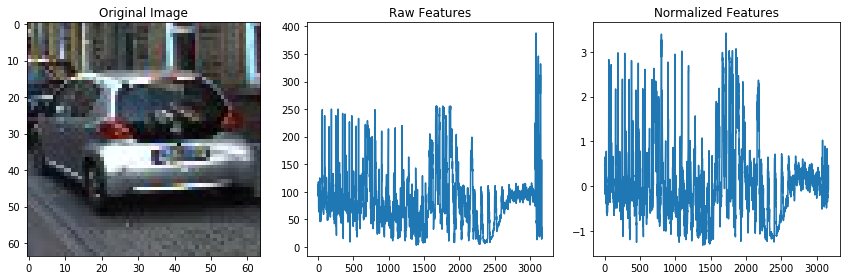

In [12]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    print(X.shape)
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(data_info['CarImages']))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(data_info['CarImages'][car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')